# Machine Learning Walkthrough


In this notebook we are going to execute a machine learning project from start to finish. We'll use techniques covered in the previous workshops but also some new material as well.

### Game plan

1. Introduce dataset and objective
    - What is the data about? What do the variables mean?
    - What is the goal with applying machine learning here? Why is classification important in this scenario?
2. Feature Engineering and EDA
    - Produce several charts to give us a better understanding of what the data is about.
    - Drop any features we deem to be unneccessary or that multicollinearity.
    - One hot encode the categorical data and standardize the numerical data.
    - Create a validation dataset from the data and set it aside until the end when evaluate final models.
3. Modeling Process
    - Determine the null accuracy and preferred performance metric.
    - We'll be using three different models in this project: Logistic Regression, Decision Trees and Random Forest.
    - Decision Trees will serve as our baseline model and we'll use Random Forest to see how much better it improves upon the baseline.
    - We'll also be parameter tuning both models — basically means determing which max_depth value produces the best model.
    - Finetune the model by dropping unneccessary features.
    - Evaluate model using a variety of metrics.
4. Evaluation and Interpretation
    - Evaluate the model on the validation dataset.
    - Discuss how successful we were with our modeling.
    - Go over what machine learning tells us about this dataset. Understand how predictions are made.

## I. Introduction

### [Personal Key Indicators of Heart Disease](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease)

From Kaggle:

2020 annual CDC survey data of 400k adults related to their health status

**What topic does the dataset cover?**

According to the CDC, heart disease is one of the leading causes of death for people of most races in the US (African Americans, American Indians and Alaska Natives, and white people). About half of all Americans (47%) have at least 1 of 3 key risk factors for heart disease: high blood pressure, high cholesterol, and smoking. Other key indicator include diabetic status, obesity (high BMI), not getting enough physical activity or drinking too much alcohol. Detecting and preventing the factors that have the greatest impact on heart disease is very important in healthcare. Computational developments, in turn, allow the application of machine learning methods to detect "patterns" from the data that can predict a patient's condition.

**Where did the dataset come from and what treatments did it undergo?**

Originally, the dataset come from the CDC and is a major part of the Behavioral Risk Factor Surveillance System (BRFSS), which conducts annual telephone surveys to gather data on the health status of U.S. residents. As the CDC describes: "Established in 1984 with 15 states, BRFSS now collects data in all 50 states as well as the District of Columbia and three U.S. territories. BRFSS completes more than 400,000 adult interviews each year, making it the largest continuously conducted health survey system in the world.". The most recent dataset (as of February 15, 2022) includes data from 2020. It consists of 401,958 rows and 279 columns. The vast majority of columns are questions asked to respondents about their health status, such as "Do you have serious difficulty walking or climbing stairs?" or "Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes]". In this dataset, I noticed many different factors (questions) that directly or indirectly influence heart disease, so I decided to select the most relevant variables from it and do some cleaning so that it would be usable for machine learning projects.

**What can you do with this dataset?**

As described above, the original dataset of nearly 300 variables was reduced to just about 20 variables. In addition to classical EDA, this dataset can be used to apply a range of machine learning methods, most notably classifier models (logistic regression, SVM, random forest, etc.). You should treat the variable "HeartDisease" as a binary ("Yes" - respondent had heart disease; "No" - respondent had no heart disease). But note that classes are not balanced, so the classic model application approach is not advisable. Fixing the weights/undersampling should yield significantly betters results. Based on the dataset, I constructed a logistic regression model and embedded it in an application you might be inspired by: https://heart-condition-checker.herokuapp.com/. Can you indicate which variables have a significant effect on the likelihood of heart disease?

### Data Dictionary

**HeartDisease:** Respondents that have ever reported having coronary heart disease (CHD) or myocardial infarction (MI) <- target variable

**BMI:** Body Mass Index (BMI)

**Smoking:** Have you smoked at least 100 cigarettes in your entire life? Note: 5 packs = 100 cigarettes

**AlcoholDrinking:** Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week

**Stroke:** Ever had a stroke?

**PhysicalHealth:** Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 was your physical health not good.

**MentalHealth:** Thinking about your mental health, for how many days during the past 30 days was your mental health not good?

**DiffWalking:** Do you have serious difficulty walking or climbing stairs?

**Sex:** Gender

**AgeCategory:** Fourteen-level age category

**Race:** Race and ethnicity

**Diabetic:** Have you ever had diabetes?

**PhysicalActivity:** Adults who reported doing physical activity or exercise during the past 30 days other than their regular job

**GenHealth:** Would you say that in general your health is...

**SleepTime:** On average, how many hours of sleep do you get in a 24-hour period?

**Asthma:** Have you ever had asthma

**KidneyDisease:** Not including kidney stones, bladder infection or incontinence, were you ever told you had kidney disease?

**SkinCancer:** Have you ever had skin cancer.


**Objective:** Our objective is to use a variety demographic, health, and behavioral data to predict if the patients in this dataset have or ever had heart disease.

In [69]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 2)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel


Load in dataset.

In [2]:
df = pd.read_csv("data/heart_2020_cleaned_sample.csv")
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,28.29,Yes,Yes,No,0.0,0.0,No,Male,55-59,White,No,Yes,Excellent,6.0,No,No,Yes
1,No,34.75,No,No,No,3.0,0.0,Yes,Female,70-74,White,Yes,Yes,Good,6.0,No,Yes,Yes
2,No,31.00,Yes,No,No,0.0,2.0,No,Female,25-29,White,No,Yes,Very good,7.0,No,No,No
3,No,27.89,No,No,No,0.0,0.0,No,Male,40-44,Hispanic,No,Yes,Excellent,8.0,No,No,No
4,No,23.63,Yes,No,No,0.0,15.0,No,Male,55-59,White,No,No,Fair,7.0,Yes,No,No


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HeartDisease      50000 non-null  object 
 1   BMI               50000 non-null  float64
 2   Smoking           50000 non-null  object 
 3   AlcoholDrinking   50000 non-null  object 
 4   Stroke            50000 non-null  object 
 5   PhysicalHealth    50000 non-null  float64
 6   MentalHealth      50000 non-null  float64
 7   DiffWalking       50000 non-null  object 
 8   Sex               50000 non-null  object 
 9   AgeCategory       50000 non-null  object 
 10  Race              50000 non-null  object 
 11  Diabetic          50000 non-null  object 
 12  PhysicalActivity  50000 non-null  object 
 13  GenHealth         50000 non-null  object 
 14  SleepTime         50000 non-null  float64
 15  Asthma            50000 non-null  object 
 16  KidneyDisease     50000 non-null  object

We have 13 categorical features, 4 continuous featues, and one categorical target variable.

We also do not have any null values, so we can skip imputation.

## Exploratory Data Analysis & Feature Engineering

### EDA

Let's first get a sense of the distributions of the variables in the dataset.

Plot the histogram and boxplots of all the numerical variables.

In [4]:
#Grab subset of numerical data
df_num = df.select_dtypes("number")
df_num.head()

,BMI,PhysicalHealth,MentalHealth,SleepTime
0,28.29,0.0,0.0,6.0
1,34.75,3.0,0.0,6.0
2,31.00,0.0,2.0,7.0
3,27.89,0.0,0.0,8.0
4,23.63,0.0,15.0,7.0


Plot a 4x2 dimension subplot that plots a histogram and boxplot for every continous variable.

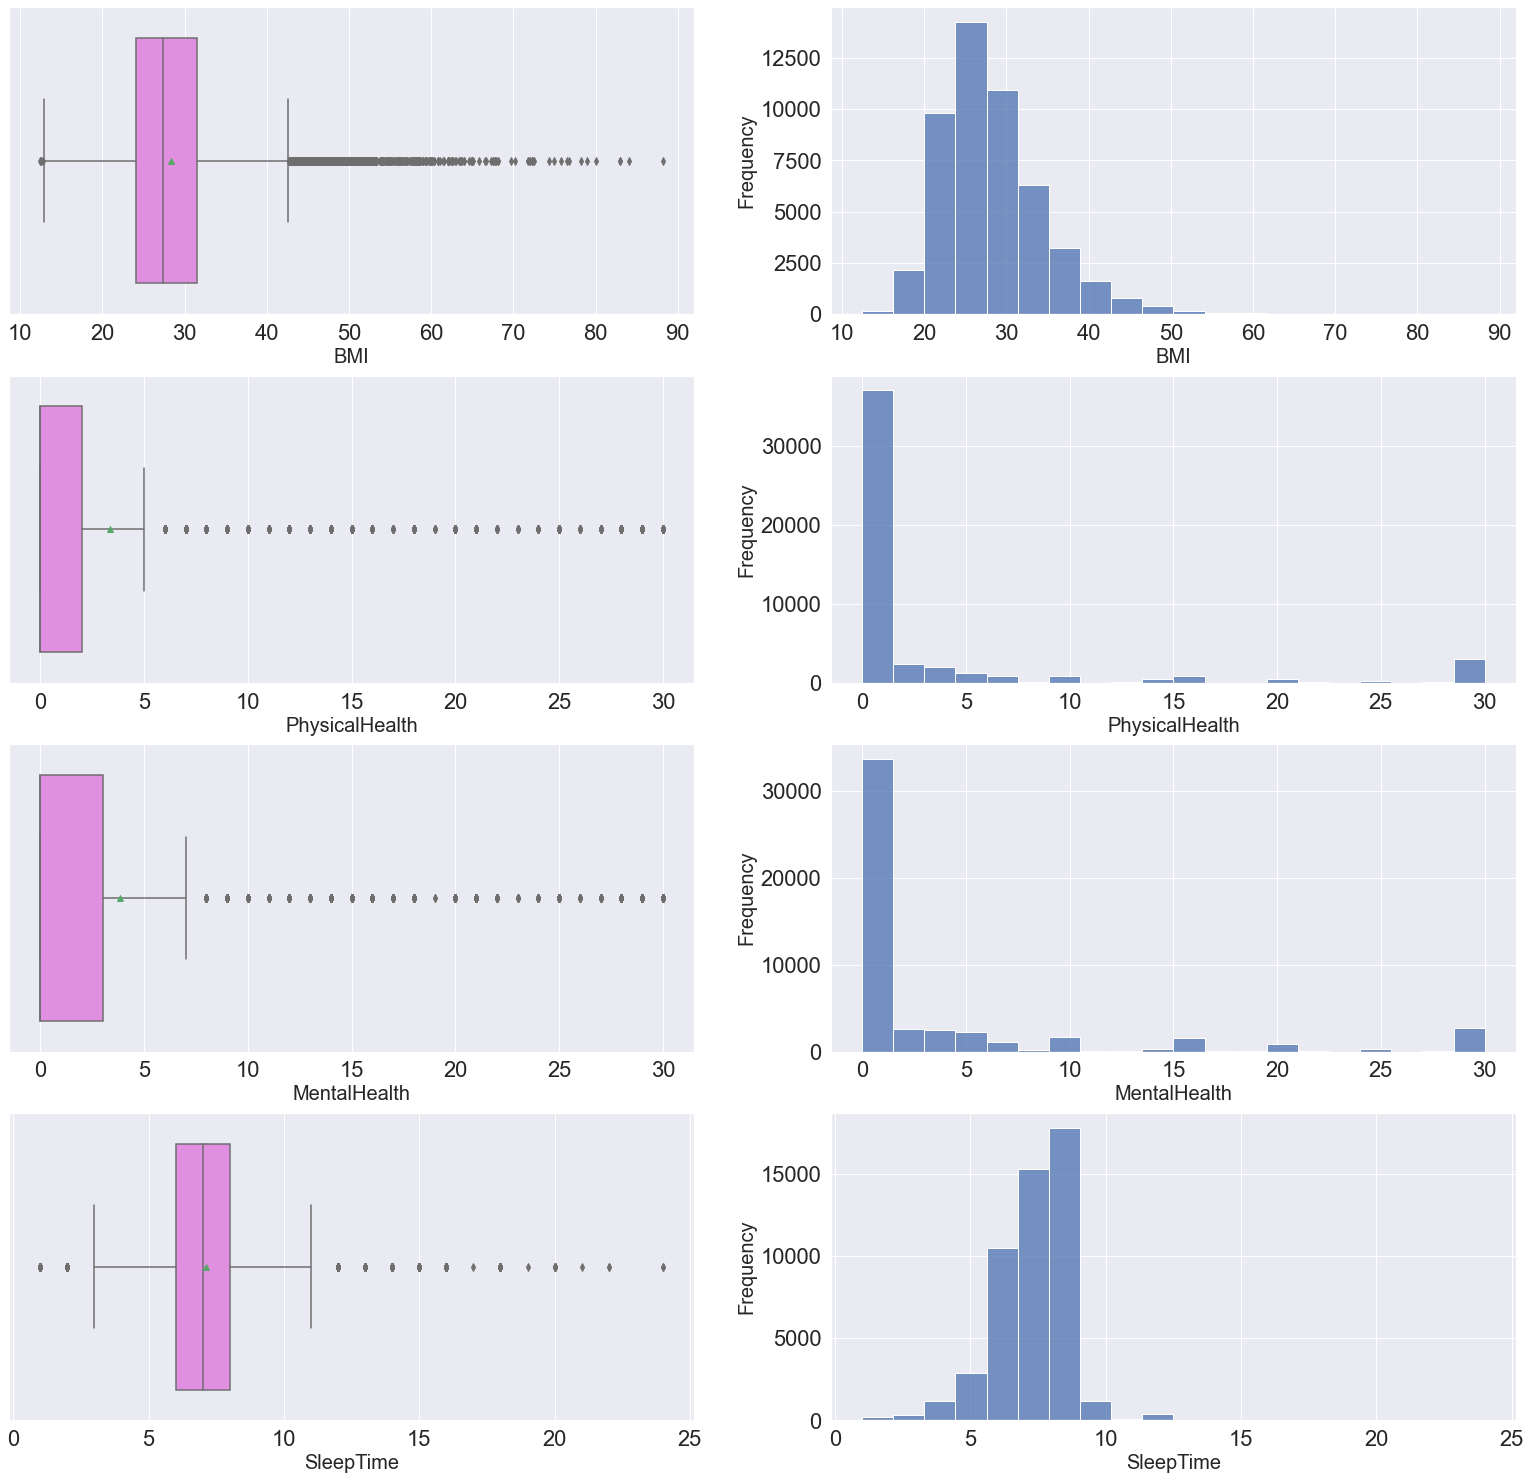

In [5]:
cols = df_num.columns
nrows = len(cols) # Number of continous variables
ncols = 2 #One col for the histogram one for the boxplot

fig, axes = plt.subplots(
        nrows=nrows,
        ncols = ncols,
        figsize=(27, 26),
    )  #

for row in range(nrows):
    feature = cols[row]
    sns.boxplot(data=df_num, x=feature, ax=axes[row, 0] , showmeans=True, color="violet")
    sns.histplot(data=df_num, x=feature, ax=axes[row, 1], bins=20, palette="winter")
    
    axes[row, 0].set_xlabel(xlabel=feature, fontdict={"size":20})
    axes[row, 1].set_xlabel(xlabel=feature, fontdict={"size":20})
    axes[row, 1].set_ylabel(ylabel="Frequency", fontdict = {"size": 20})

What can we see from this plot? Anything of note?

Now for the categorical data.

In [6]:
df_cat = df.select_dtypes("object")
df_cat.head()

,HeartDisease,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
0,No,Yes,Yes,No,No,Male,55-59,White,No,Yes,Excellent,No,No,Yes
1,No,No,No,No,Yes,Female,70-74,White,Yes,Yes,Good,No,Yes,Yes
2,No,Yes,No,No,No,Female,25-29,White,No,Yes,Very good,No,No,No
3,No,No,No,No,No,Male,40-44,Hispanic,No,Yes,Excellent,No,No,No
4,No,Yes,No,No,No,Male,55-59,White,No,No,Fair,Yes,No,No


Check the cardinality

In [7]:
df_cat.nunique()

HeartDisease         2
Smoking              2
AlcoholDrinking      2
Stroke               2
DiffWalking          2
Sex                  2
AgeCategory         13
Race                 6
Diabetic             4
PhysicalActivity     2
GenHealth            5
Asthma               2
KidneyDisease        2
SkinCancer           2
dtype: int64

Plot the frequencies of the groups in each categorical variable in a 7x2 dimensional plot

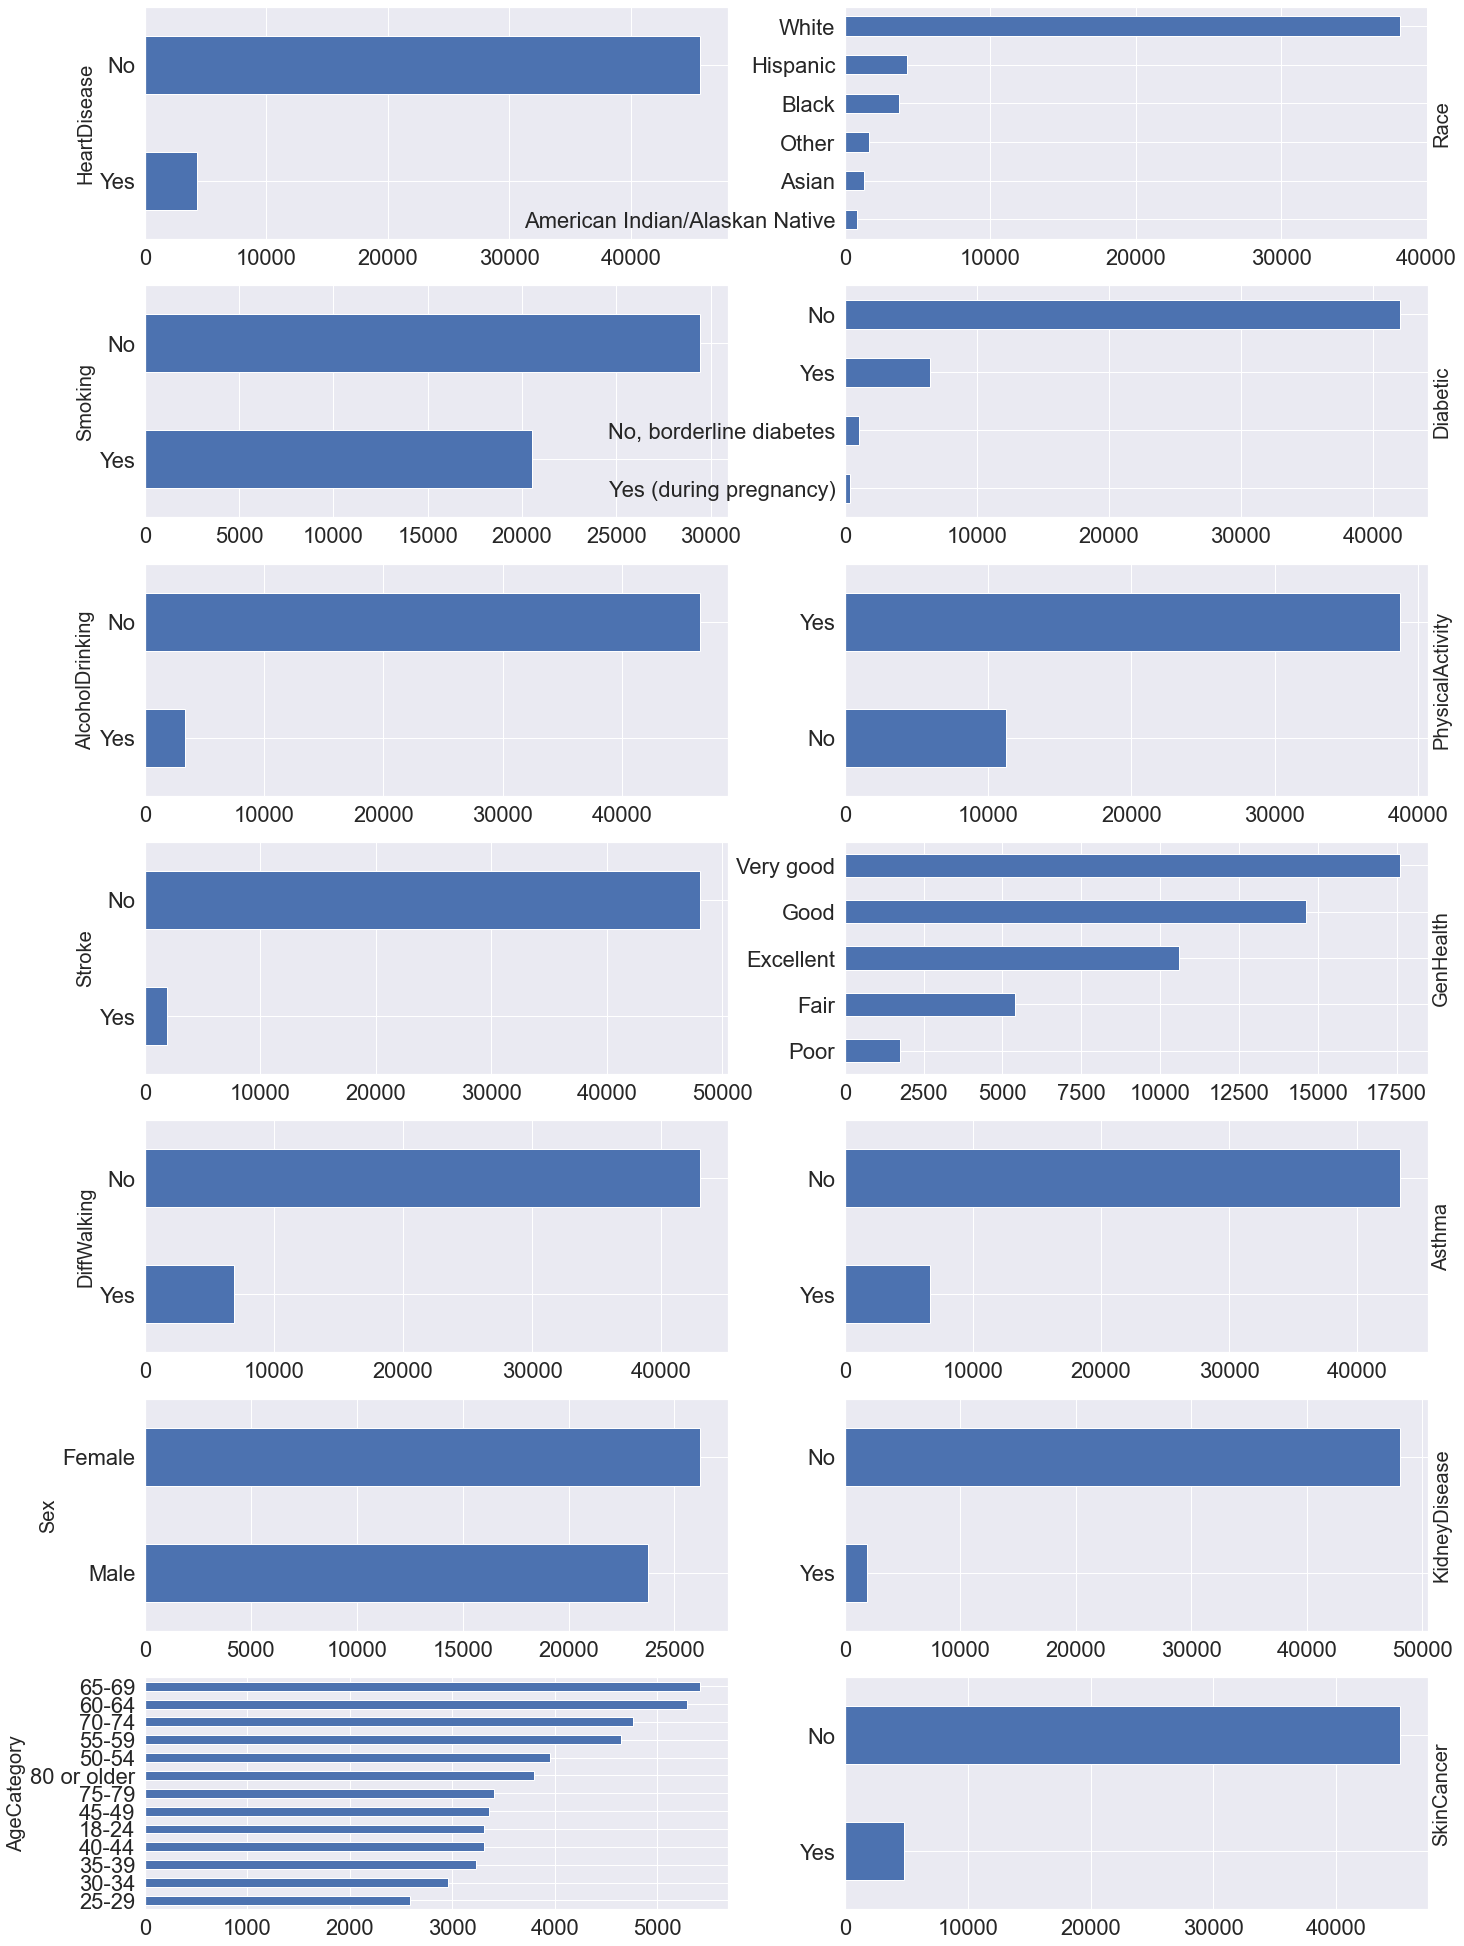

In [8]:
cols = df_cat.columns
nrows = len(cols)//2 # Number of categorical variables divided by 2
ncols = 2 

normalize = False # Set to True to view proporitions

fig, axes = plt.subplots(
        nrows=nrows,
        ncols = ncols,
        figsize=(23, 35),
    ) 

for i in range(nrows):
    feature1 = cols[i]
    feature2 = cols[i+7]
    
    axes[i,0].set_ylabel(feature1, fontdict={"size": 20})
    axes[i,1].set_ylabel(feature2, fontdict={"size": 20})
    axes[i,1].yaxis.set_label_position("right")
    df_cat[feature1].value_counts(normalize=normalize).sort_values().plot(kind = "barh", ax=axes[i, 0])
    df_cat[feature2].value_counts(normalize=normalize).sort_values().plot(kind = "barh", ax=axes[i, 1])
    

What does this plot tell us? 


Set `normalize = True` to view percentages and rerun the code.

Now let's see how the independent variables interact with the target variable. 

First up, the continous features.

For this part, we're going to use a pairplot that plots every pair of variable against one another in a scatter plot and we're going to color the dots with the target variable.

/var/folders/lj/w4hy005d5vx9qy3lrwz0xdl80000gn/T/ipykernel_35987/2465092075.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num["target"] = df["HeartDisease"]


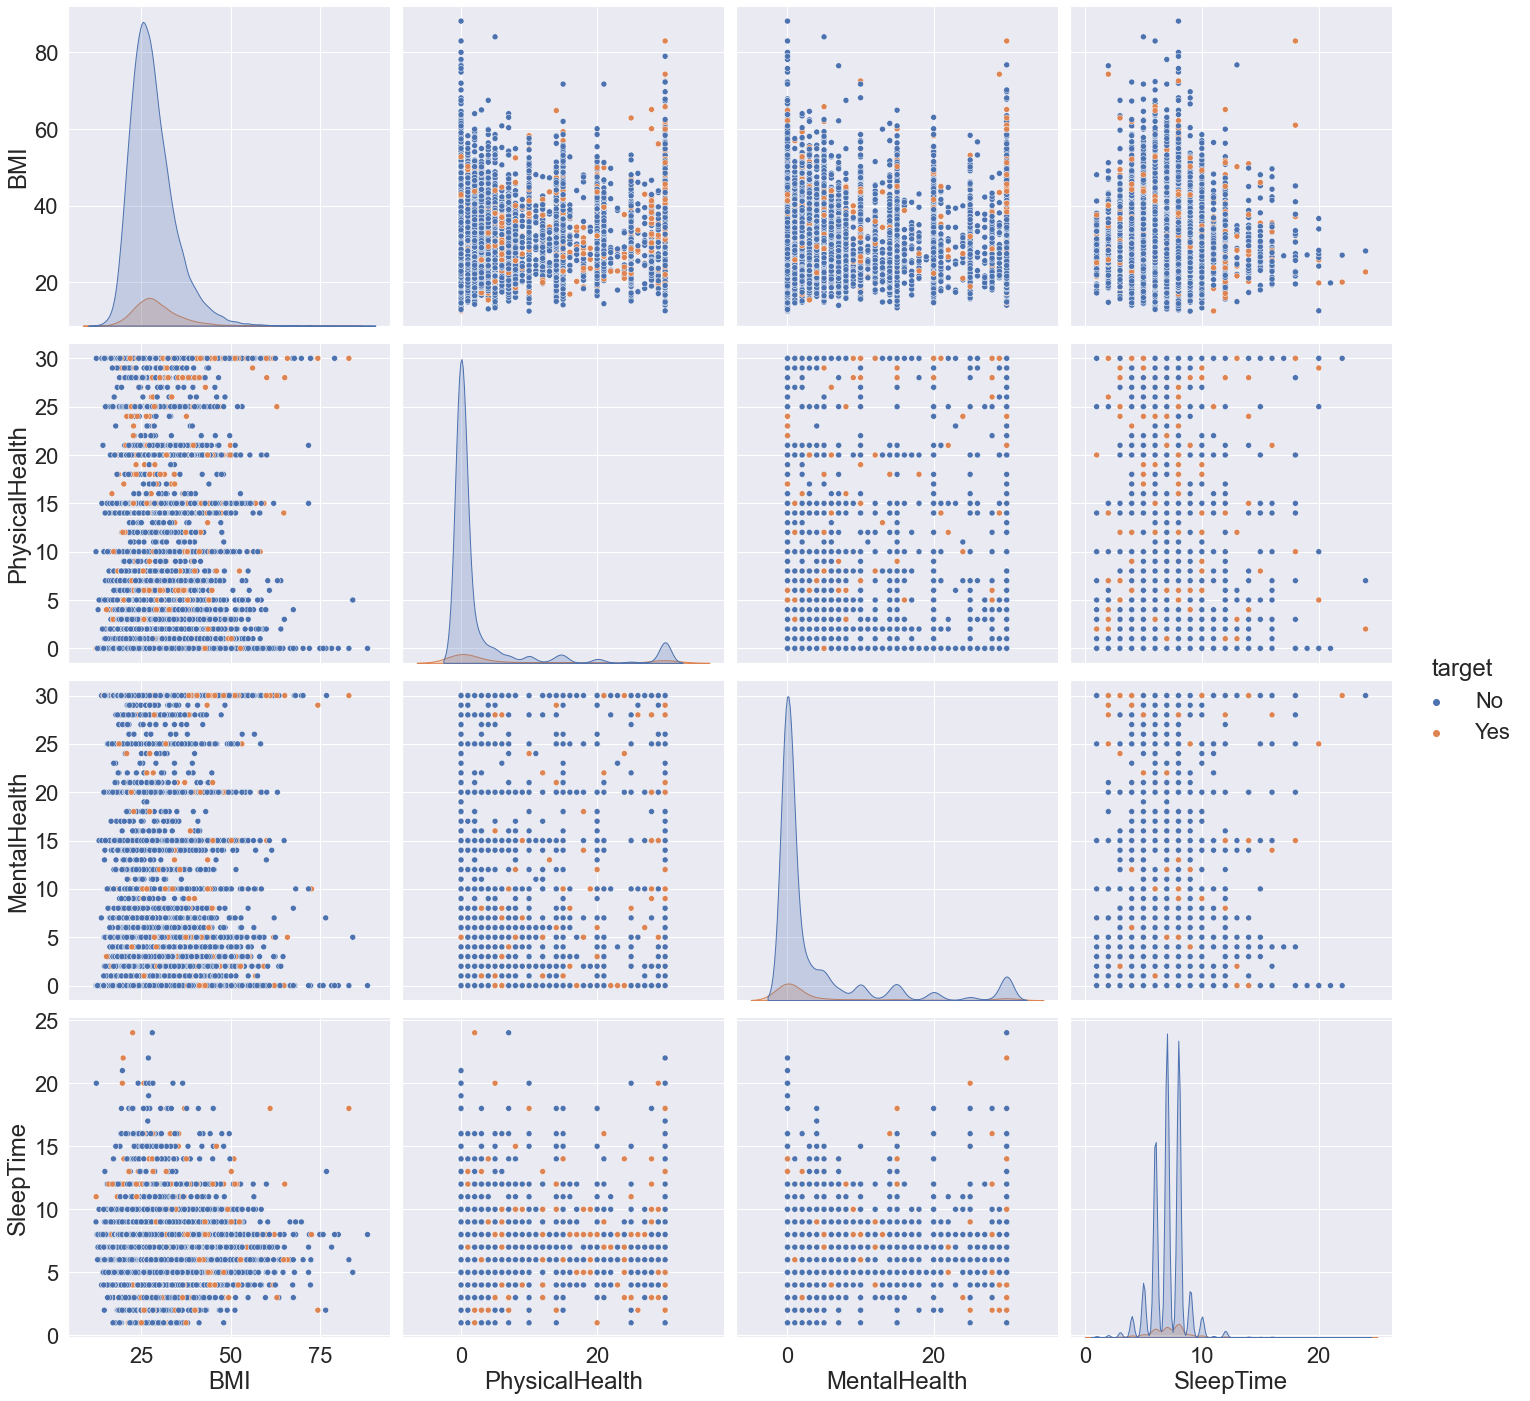

In [9]:
#Put the target variable back in df_num
df_num["target"] = df["HeartDisease"]

sns.pairplot(data=df_num, hue="target", height = 5, )

Does this plot tell us anything about the relationship between the continous variables and the target variable?

Are there any distinct patterns?

For the categorical data, let's plot the average `HeartDisease` rate by each variable.

<AxesSubplot:ylabel='Smoking'>

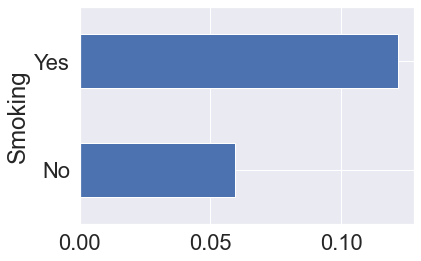

In [10]:
df_cat.groupby("Smoking").HeartDisease.apply(lambda x: sum(x=="Yes")/len(x)).plot(kind = "barh")

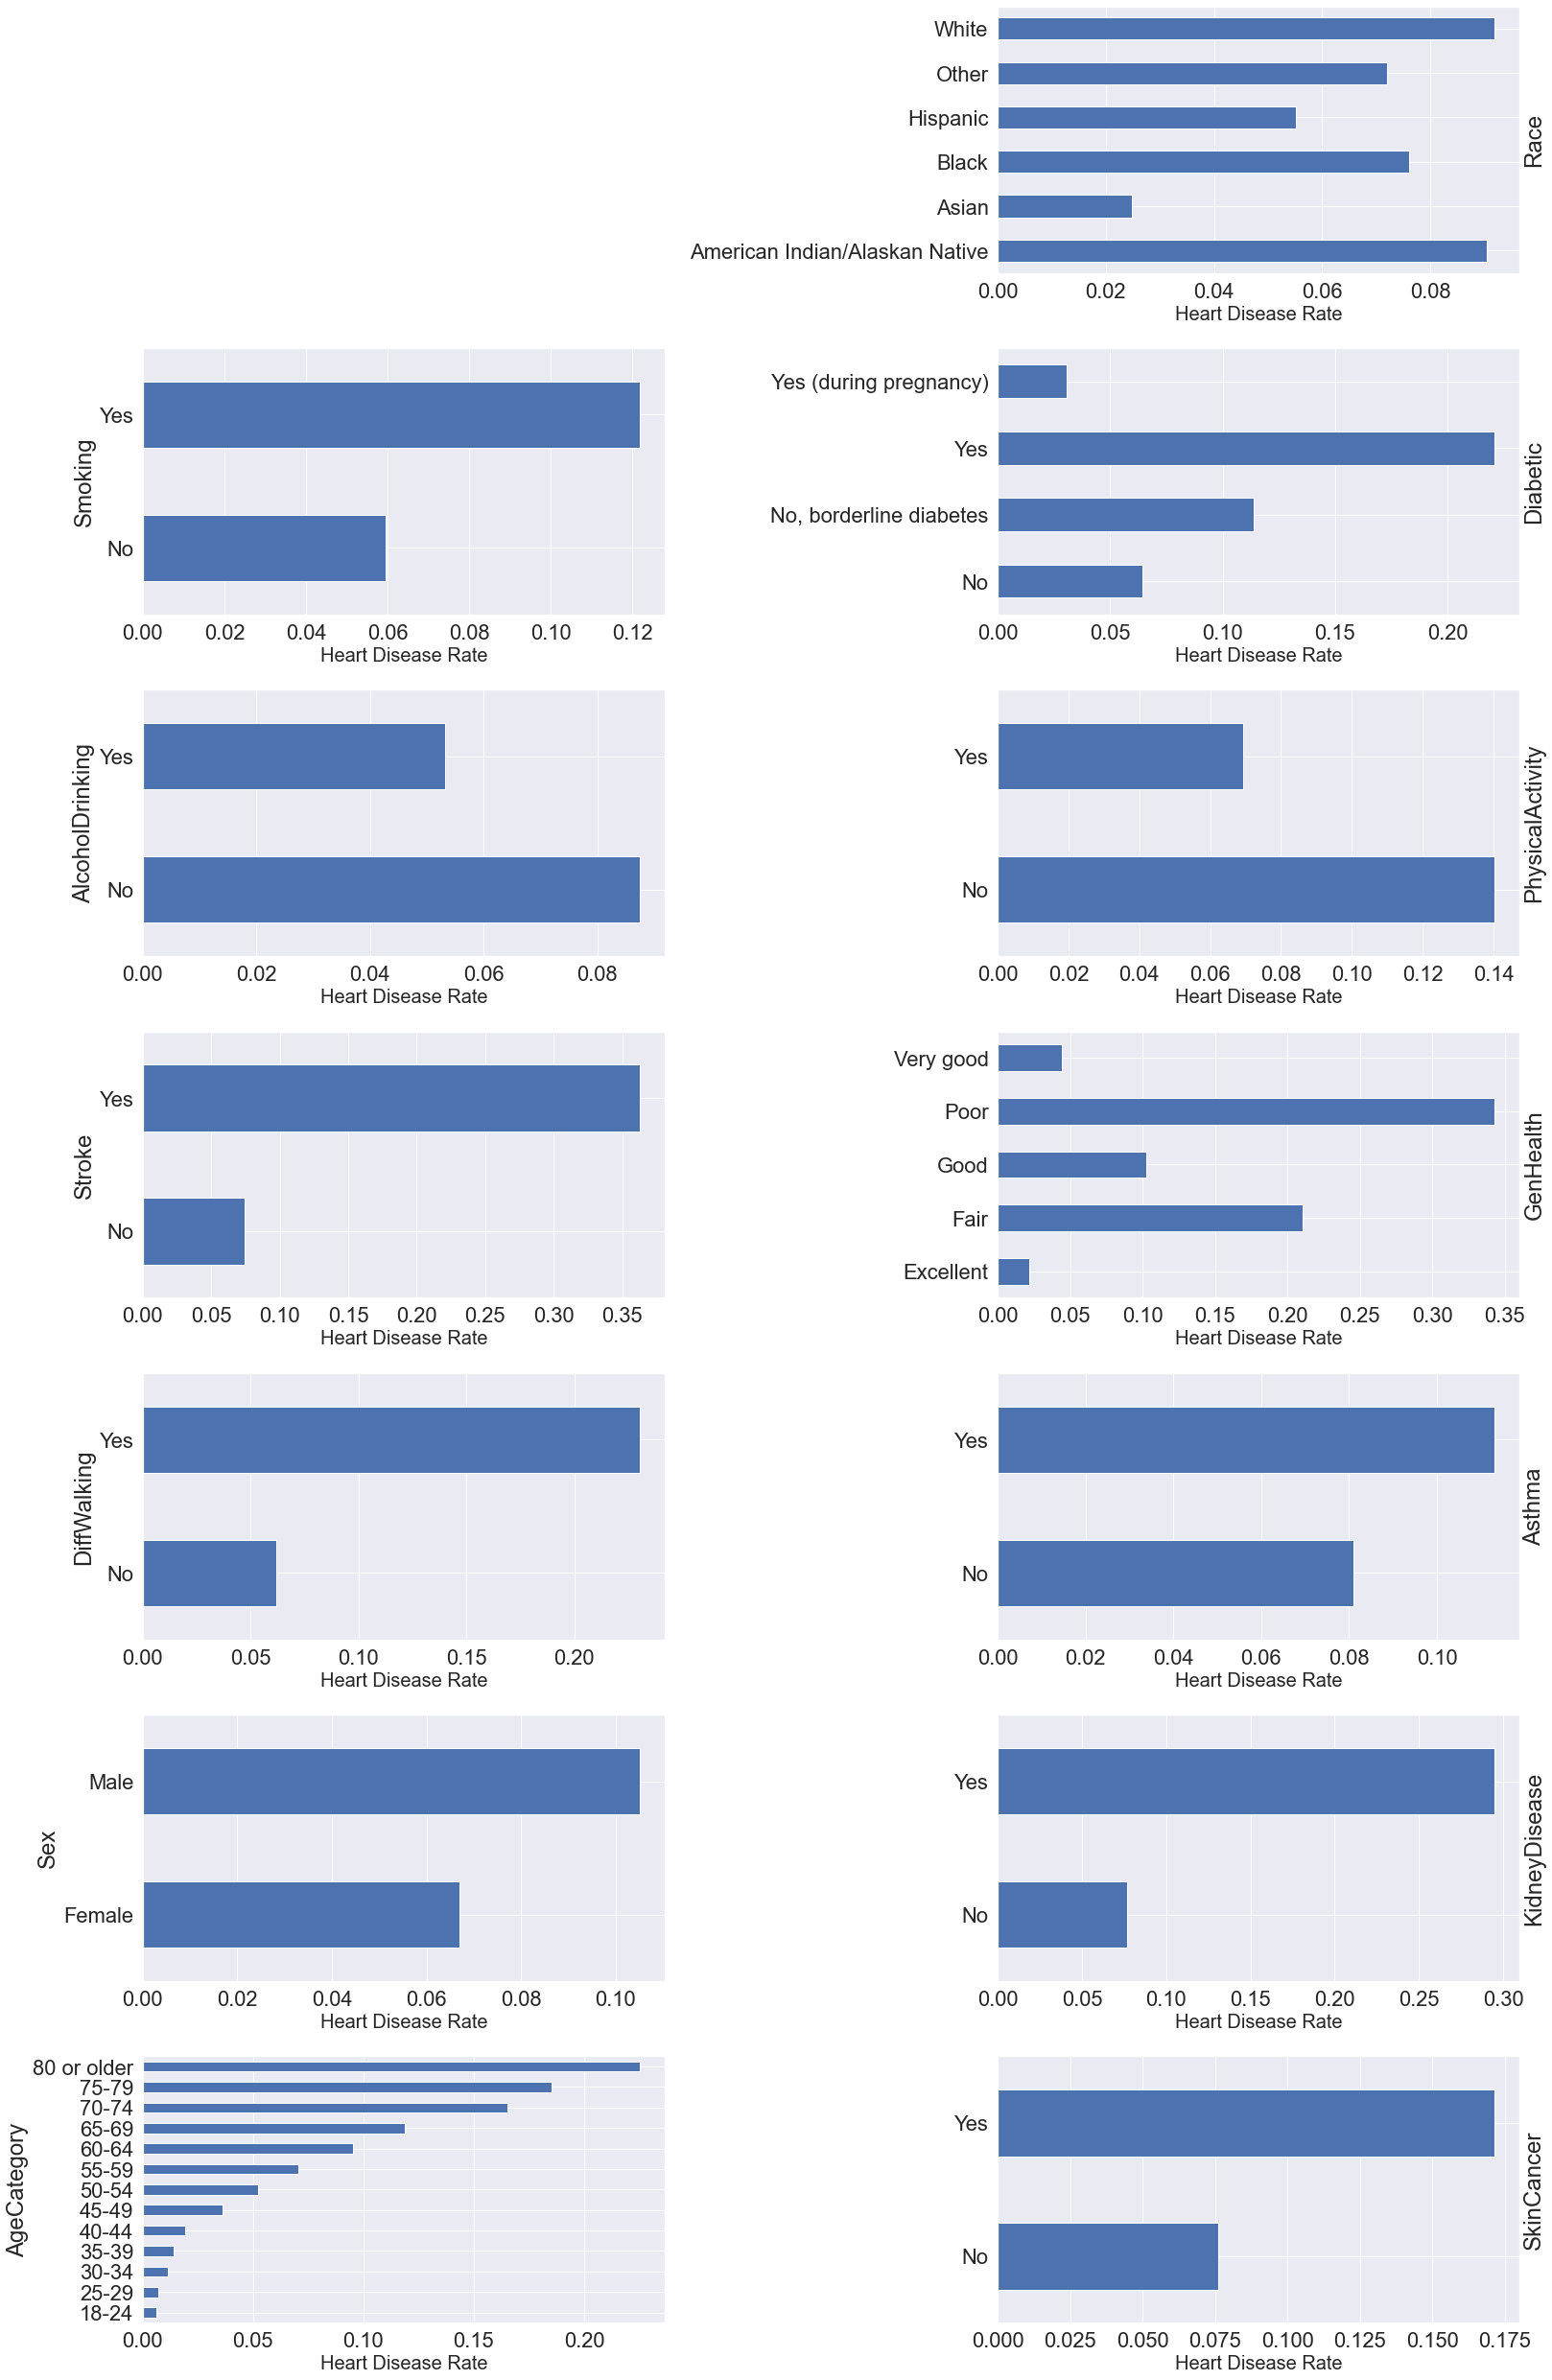

In [11]:
cols = df_cat.columns
nrows = len(cols)//2 # Number of categorical variables divided by 2
ncols = 2 

normalize = False # Set to True to view proporitions

fig, axes = plt.subplots(
        nrows=nrows,
        ncols = ncols,
        figsize=(23, 35),
    ) 

for i in range(nrows):
    feature1 = cols[i]
    feature2 = cols[i+7]
    
    if feature1 == "HeartDisease":
        axes[i, 0].axis('off')
    else:    
        df_cat.groupby(feature1).HeartDisease.apply(lambda x: sum(x=="Yes")/len(x)).plot(kind = "barh", ax = axes[i, 0])
        
    df_cat.groupby(feature2).HeartDisease.apply(lambda x: sum(x=="Yes")/len(x)).plot(kind = "barh", ax = axes[i, 1])
    
    axes[i,0].set_xlabel("Heart Disease Rate", fontdict={"size": 20})
    axes[i,1].set_xlabel("Heart Disease Rate", fontdict={"size": 20})
    axes[i,1].yaxis.set_label_position("right")
    fig.tight_layout()


What do we see here? Anything worth reporting?

### Feature Engineering

We know that we need to transform the data before we can model.

We're going to:

- Label encode the target variable
- Scale the numerical features
- One hot encode the categorical data

However before we start, let's convert the `AgeCategory` to number so as to reduce the number columns that result from creating one hot-encoding.

In [12]:
df["AgeCategory"].unique()

array(['55-59', '70-74', '25-29', '40-44', '65-69', '80 or older',
       '18-24', '45-49', '75-79', '50-54', '30-34', '35-39', '60-64'],
      dtype=object)

In [13]:
df["AgeCategory"].nunique()

13

For this part let's convert this feature to a continous but grabbing the first number in the age bin and convert it to a float.

This obviously is not a precise age value for the patients but since there's an order to the variables we can make this work

In [14]:
#Create Age column with age data
df["Age"] = df.AgeCategory.apply(lambda x:x[:2]).astype(float)

In [15]:
df.Age.head()

0    55.0
1    70.0
2    25.0
3    40.0
4    55.0
Name: Age, dtype: float64

In [16]:
#Drop Age Category
df.drop("AgeCategory", axis = 1, inplace=True)

Separate the target variable from the data.

In [17]:
X = df.drop("HeartDisease", axis = 1)
y = df.HeartDisease

In [18]:
X.dtypes

BMI                 float64
Smoking              object
AlcoholDrinking      object
Stroke               object
PhysicalHealth      float64
MentalHealth        float64
DiffWalking          object
Sex                  object
Race                 object
Diabetic             object
PhysicalActivity     object
GenHealth            object
SleepTime           float64
Asthma               object
KidneyDisease        object
SkinCancer           object
Age                 float64
dtype: object

Before we scale and one hot encode data, let's first split it into training and validation datasets.

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.25, random_state=1, stratify=y)

Label encode the target variable

In [20]:
#Intialize label encoder
le = LabelEncoder()
#Fit transform on the training target variable
y_train = le.fit_transform(y_train)
#Transform the testing target variable
y_valid = le.transform(y_valid)

In [21]:
le.classes_

array(['No', 'Yes'], dtype=object)

In [22]:
le.transform(["No", "Yes"])

array([0, 1])

"No" -> 0

"Yes" -> 1

This time for the one hot encoding we're going to create a pipeline in fell swoop using `Pipeline` and `ColumnTransformer`.

In [23]:
#Collect the features
feat_cols = X_train.columns

#Make a list of the numerical features
num_cols = X_train.select_dtypes("number").columns.tolist()

#Make a boolean mask that outputs an array of booleans that true for continuous data and false otherwise
num_cols_mask = feat_cols.isin(num_cols)
num_cols_mask

array([ True, False, False, False,  True,  True, False, False, False,
       False, False, False,  True, False, False, False,  True])

Create first `Pipeline` object in the transformations

In [24]:
#Intialize pipeline object that will be used to scale numerical data
pipeline_num = Pipeline([("scale", StandardScaler())])

#Create a tuple that has three values, 
# 1. Step name
# 2. The pipeline
# 3. column mask which tells sklearn which columns to transform which not to
column_transform_scale_step = ("numerical", pipeline_num, num_cols_mask)

Repeat proceces for categorical data

In [25]:

cat_cols = X_train.select_dtypes("object").columns.tolist()
cat_cols_mask= feat_cols.isin(cat_cols)

pipeline_cat = Pipeline([("ohe", OneHotEncoder(categories='auto', 
                                               handle_unknown='error', 
                                               sparse=False, drop="first"))])
column_transform_ohe_step = ("cat", pipeline_cat, cat_cols_mask)


In [26]:
#Organize the pipelines in a list

transformer_steps = [column_transform_scale_step, column_transform_ohe_step]

#Intialize the ColumnTransformer object with the transformer steps

feat_eng_pipe = ColumnTransformer(transformers=transformer_steps)

Now we feature engineer the data.

In [27]:
#Fit transform the train dataset
X_train = feat_eng_pipe.fit_transform(X_train)

#Transform the testing dataset with the rules learned from the training dataset 
X_valid = feat_eng_pipe.transform(X_valid)

This demonstrates the true value of this process. We can quickly and cleanly transform any new batches of data to confirm to the rules established by the training dataset.

In [28]:
#View result
X_train

array([[-1.01060675, -0.4248059 , -0.48929978, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.55327719, -0.4248059 , -0.48929978, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.10094824, -0.4248059 , -0.11163968, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.56732163,  0.45702202, -0.48929978, ...,  1.        ,
         0.        ,  1.        ],
       [-0.65264836, -0.4248059 , -0.23752638, ...,  0.        ,
         0.        ,  0.        ],
       [-0.19578042,  3.35445662, -0.48929978, ...,  0.        ,
         0.        ,  0.        ]])

Let's put this back into a pandas dataframe

In [29]:
#Access pipeline data to so we can name the one hot encoded columns
cat_col_names = feat_eng_pipe.named_transformers_["cat"]["ohe"].get_feature_names(cat_cols).tolist()
    
#Create list of column names
column_names = num_cols + cat_col_names

X_train = pd.DataFrame(data=X_train, columns=column_names)
X_valid = pd.DataFrame(data=X_valid, columns=column_names)
X_train.head()

,BMI,PhysicalHealth,MentalHealth,SleepTime,Age,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,DiffWalking_Yes,Sex_Male,...,Diabetic_Yes,Diabetic_Yes (during pregnancy),PhysicalActivity_Yes,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_Yes,KidneyDisease_Yes,SkinCancer_Yes
0,-1.010607,-0.424806,-0.489300,-0.072315,-0.686023,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.553277,-0.424806,-0.489300,0.628053,-0.686023,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.100948,-0.424806,-0.111640,-1.473051,-1.238926,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.064924,-0.046880,-0.237526,-2.173419,0.972686,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.633808,-0.424806,-0.489300,-0.072315,1.249138,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Voila! We have our finalized dataset and we can move onto the machine learning part.

We're going to set aside the validation dataset until the end when evaluate our model on it.

## Modeling

Now the fun begins!

But before we can start modeling we need to calculate the null accuracy.

In [30]:
pd.value_counts(y_train, normalize=True)


0    0.914827
1    0.085173
dtype: float64

We have a null accuracy of 91.5%

How can we translate that number into layman's terms? What does it mean for our modeling?

Another important point we need to go over is the issue different error types.

False negative error: Classifying a patient as not having heart disease but in reality does.

False positive error: Classifying a patient as having heart disease but in reality does not.


Which one in your opinion is the one that we should minimize? And based on that answer which metric should focus on in our approach.

Since we're going to be engaging in frequent modeling and model evaluation. Let's create a helper function that takes into labels and predictions and outputs a dataframe of classification metrics.

In [31]:
def model_eval(train_labels, test_labels, train_preds, test_preds):
    
    metric_funcs = [accuracy_score, precision_score, recall_score, f1_score]
    
    train_scores = [func(train_labels, train_preds) for func in metric_funcs]
    test_scores = [func(test_labels, test_preds) for func in metric_funcs]
    
    
    pred_df = pd.DataFrame(data={"Training": train_scores, "Testing": test_scores},
                          index = ["Accuracy Score", "Precision Score", "Recall", "F1 Score"])
    return pred_df

### Logistic Regression


How well does logistic regression do on the dataset?

Let's apply cross validation to the dataset for the four metrics using logistic regression.

In [32]:
#Make list of metric functions
metrics = ['accuracy', 'precision', 'recall', 'f1']

kf = KFold(5)

lr = LogisticRegression()

for m in metrics:
    cv_results = cross_val_score(lr, X_train, y_train, cv = kf, scoring=m)
    print("Mean {} score is {}".format(m, cv_results.mean().round(3)))

Mean accuracy score is 0.916
Mean precision score is 0.531
Mean recall score is 0.114
Mean f1 score is 0.187


Thoughts on the logistic regression model's performance?

How does the accuracy score compare to the null accuracy?

What do the precision and recall scores mean?

### Decision Trees

Perhaps decision trees will yield better results for us.

#### Grid Searching

As you may recall, decision trees are quite sensitive to their parameters (max_depth, min_samples_split, etc...). We want to find the best set parameters according to a chosen metric.

This is where Grid-Search comes, which is sklearn's tool for parameter-tuning.


Grid-Search is a brute-force method that executes cross-validation for possible group of parameters from a set of parameter ranges.

Here's an example:

The range of input values for parameter A are (0, 1)

The range of input values for parameter B are (2, 3)

Grid Search executes cross-validation for parameters combinations of:

- A = 0 & B = 1
- A = 0 & B = 3
- A = 2 & B = 1
- A = 2 & B = 3

To use sklearn's tool, we first have to initialize our param grid which holds the possible input values for the parameters we want to tune.

We're going to be tuning `max_depth` and `min_samples_leaf`

In [33]:
param_grid = {"max_depth": np.arange(5, 50, 5),
             "min_samples_leaf": np.arange(20, 200, 10)}

param_grid["max_depth"].shape[0] * param_grid["min_samples_leaf"].shape[0]

162

That's 162 different sets of parameters we're going to be tuning

Create the grid search object

In [34]:
grid_dt = GridSearchCV(DecisionTreeClassifier(), #model goes first
                      param_grid=param_grid, #followed by param_grid
                       scoring = "accuracy", # Sometimes different metrics can produce different parameter-tuned models,
                       cv = kf #Number of splits in cross-validation
                      )

In [35]:
%%time
#Time the model

#Fit the grid search object on the training data
grid_dt.fit(X_train, y_train)

CPU times: user 55.2 s, sys: 1.15 s, total: 56.4 s
Wall time: 56.3 s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45]),
                         'min_samples_leaf': array([ 20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140,
       150, 160, 170, 180, 190])},
             scoring='accuracy')

The best cross validated score

In [36]:
grid_dt.best_score_

0.9149866666666666

The best cross validated params

In [37]:
grid_dt.best_params_

{'max_depth': 5, 'min_samples_leaf': 170}

You can use `grid_dt` to make predictions because it comes pre-trained

In [45]:
grid_dt.predict(X_train)

array([0, 0, 0, ..., 0, 0, 0])

You can also access the `best_estimator_` attribute which returns of the same type as the one you parameter-tuned

In [46]:
best_dt = grid_dt.best_estimator_
type(best_dt)

sklearn.tree._classes.DecisionTreeClassifier

This is useful for looking at the feature importances and other attributes associated with the model.

Does gridsearch provide a different set of optimized parameters when we choose a different metric?

Let's try with recall

In [39]:
grid_dt = GridSearchCV(DecisionTreeClassifier(), #model goes first
                      param_grid=param_grid, #followed by param_grid
                       scoring = "recall", # Sometimes different metrics can produce different parameter-tuned models,
                       cv = kf #Number of splits in cross-validation
                      )

In [40]:
%%time
#Time the model

#Fit the grid search object on the training data
grid_dt.fit(X_train, y_train)

CPU times: user 52.9 s, sys: 788 ms, total: 53.7 s
Wall time: 53.8 s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45]),
                         'min_samples_leaf': array([ 20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140,
       150, 160, 170, 180, 190])},
             scoring='recall')

In [42]:
grid_dt.best_score_

0.13677489471201276

In [41]:
grid_dt.best_params_

{'max_depth': 45, 'min_samples_leaf': 20}

In this case, choosing a different metric does change the nature of the model.

### Random Forests

So far our modeling hasn't yield great results, therefore it's good this isn't the real world else there'd a lotta people with undiagnosed heart disease!

Perhaps we need to utilize a top-shelf model.

Allow us to introduce you to Random Forests. If you guessed that a Random Forest is a collection of Decision Trees then you'd be correct!

![](https://tse3.mm.bing.net/th?id=OIP.zBt4wgnrRYE8HSmzNK-kPgHaEz&w=690&c=7&pid=Api&p=0)

Random Forest is what's known as an ensemble model because it is ensemble of decision trees. The N trees in the forest each make their predictions and then vote together on the ensemble prediction — it's the machine learning version of "greater than the sum of its parts".

![](https://miro.medium.com/max/1240/1*EemYMyOADnT0lJWSXmTDdg.jpeg)

Important things to remember about Random Forest

- Each tree in the forest is not trained on the same data and features — that would be counter-intuitive because you would up end up with dozens of duplicate trees.
- The trees are trained subset (usually a random 2/3) of the features and a bootstrapped sample to decorrelate the trains.
- To further decorrelate the trees, pruning trees is discouraged for the purpose of overfitting. Yes that's right we want the individual trees to be overfit.

Let's cross validate a Random Forest model with 50 trees. The `n_estimators` argument is where specify the number of trees.

In [48]:
rf = RandomForestClassifier(n_estimators=50)

cv_results = cross_val_score(rf, X_train, y_train, cv = 5)
cv_results.mean()

0.90992

Any improvement?

Let's bring in grid search to see if we can improve on this result.

We'll be tuning the n_estimator parameter.

In [49]:
param_grid = {"n_estimators":np.arange(50, 300, 25)} # 50, 75, 100, 125...

grid_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv = 5, scoring = "accuracy")

grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': array([ 50,  75, 100, 125, 150, 175, 200, 225, 250, 275])},
             scoring='accuracy')

In [50]:
grid_rf.best_score_

0.9110666666666667

In [51]:
grid_rf.best_params_

{'n_estimators': 250}

In [53]:
best_rf = grid_rf.best_estimator_

How'd we do?

The downside of Grid Search is that it can take a long time, especially when you have a high number parameters, a heavy model, and big data.

RandomSearchCV is a solution to this issue because it randomly selects n of parameters sets to grid search. You're not guaranteed to find the best set of parameters but if you're pressed for time and memory then it's a workable option.

In [52]:
#Initializing Randomized SearchCV works just like GridSearch except it n_iter is used to randomly select 
#the n parameters to test.
# rs_grid = RandomizedSearchCV(RandomForestClassifier(), param_grid=param_grid, cv = 5, scoring="accuracy", 
#                             n_iter=3)

### Evaluation

It's time to bring back our validation dataset to get a stronger sense of how well our models on out-of-sample data.

We're using use the logistic regression, decision tree, and random forest models we created to make predictions on the validation features and evaluate them on a variety of metrics.

In [56]:
#Refit logisic regression
lr = LogisticRegression()
lr.fit(X_train, y_train)

#Make predictions
lr_preds = lr.predict(X_valid)
dt_preds = best_dt.predict(X_valid)
rf_preds = best_rf.predict(X_valid)

In [ ]:
classification_report

Apply the `classification_report` and `confusion_matrix` functions to the predictions

Logistic Regression

In [58]:
confusion_matrix(y_valid, lr_preds)

array([[11304,   131],
       [  955,   110]])

In [60]:
print(classification_report(y_valid, lr_preds))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     11435
           1       0.46      0.10      0.17      1065

    accuracy                           0.91     12500
   macro avg       0.69      0.55      0.56     12500
weighted avg       0.88      0.91      0.89     12500



What does this more granular evaluation of the data tell us about the success of the logistic regression model?

Decision Trees

In [61]:
confusion_matrix(y_valid, dt_preds)

array([[11236,   199],
       [  929,   136]])

In [62]:
print(classification_report(y_valid, dt_preds))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     11435
           1       0.41      0.13      0.19      1065

    accuracy                           0.91     12500
   macro avg       0.66      0.56      0.57     12500
weighted avg       0.88      0.91      0.89     12500



Do Decision Trees perform better, worse, or the same as Logisitic Regression?

And for Random Forests

In [63]:
confusion_matrix(y_valid, rf_preds)

array([[11287,   148],
       [  961,   104]])

In [64]:
print(classification_report(y_valid, rf_preds))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     11435
           1       0.41      0.10      0.16      1065

    accuracy                           0.91     12500
   macro avg       0.67      0.54      0.56     12500
weighted avg       0.88      0.91      0.89     12500



How does Random Forest compare to the other two models?

### Interpretation


So our models did not turn out that well but perhaps we can learn something from about the relationship between the features and the outcome variable.


We can use Logistic Regression coefficients and features importances from Decision Trees and Random Forests to see which features have the strongest and weakest predictive power.

Analyze the Logisitic Regression coefficients.

In [65]:
coefs = lr.coef_[0]
coefs = pd.Series(index=column_names, data = coefs)
coefs

BMI                                 0.044432
PhysicalHealth                      0.054512
MentalHealth                        0.025417
SleepTime                          -0.032793
Age                                 0.980775
Smoking_Yes                         0.396098
AlcoholDrinking_Yes                -0.285886
Stroke_Yes                          1.038307
DiffWalking_Yes                     0.283167
Sex_Male                            0.692318
Race_Asian                         -0.759305
Race_Black                         -0.109482
Race_Hispanic                      -0.027624
Race_Other                         -0.022699
Race_White                          0.092743
Diabetic_No, borderline diabetes    0.130004
Diabetic_Yes                        0.472205
Diabetic_Yes (during pregnancy)    -0.569397
PhysicalActivity_Yes                0.032140
GenHealth_Fair                      1.540846
GenHealth_Good                      1.107864
GenHealth_Poor                      1.862361
GenHealth_

Sort them from greatest to least

In [66]:
coefs.sort_values(ascending=False)

GenHealth_Poor                      1.862361
GenHealth_Fair                      1.540846
GenHealth_Good                      1.107864
Stroke_Yes                          1.038307
Age                                 0.980775
Sex_Male                            0.692318
KidneyDisease_Yes                   0.547786
GenHealth_Very good                 0.495132
Diabetic_Yes                        0.472205
Smoking_Yes                         0.396098
DiffWalking_Yes                     0.283167
Asthma_Yes                          0.220454
SkinCancer_Yes                      0.196090
Diabetic_No, borderline diabetes    0.130004
Race_White                          0.092743
PhysicalHealth                      0.054512
BMI                                 0.044432
PhysicalActivity_Yes                0.032140
MentalHealth                        0.025417
Race_Other                         -0.022699
Race_Hispanic                      -0.027624
SleepTime                          -0.032793
Race_Black

- Which features are the most and least associated with heart disease? 
- What features have very little predictive power?

In [ ]:
DecisionTreeClassifier()

Let's see if the feature importances of decision trees and random forest tell a similar story.

Feature importance as defined by sklearn is "The (normalized) total reduction of the criterion brought by that feature." Basically, what proportion of the information is a feature responsible for.

In [67]:
dt_fi = best_dt.feature_importances_
dt_fi = pd.Series(index=column_names, data=dt_fi)
dt_fi.sort_values(ascending = False)

Age                                 0.238673
BMI                                 0.145168
Stroke_Yes                          0.107253
DiffWalking_Yes                     0.062927
GenHealth_Poor                      0.061391
Sex_Male                            0.056269
GenHealth_Fair                      0.050930
PhysicalHealth                      0.042521
Diabetic_Yes                        0.040017
GenHealth_Good                      0.039548
SleepTime                           0.036948
MentalHealth                        0.027729
Smoking_Yes                         0.019787
KidneyDisease_Yes                   0.016809
GenHealth_Very good                 0.014252
SkinCancer_Yes                      0.013413
PhysicalActivity_Yes                0.011775
Race_White                          0.005690
Asthma_Yes                          0.004989
Race_Black                          0.002591
AlcoholDrinking_Yes                 0.000645
Race_Hispanic                       0.000398
Race_Other

In [68]:
rf_fi = best_rf.feature_importances_
rf_fi = pd.Series(index=column_names, data=rf_fi)
rf_fi.sort_values(ascending = False)

BMI                                 0.276854
Age                                 0.121501
SleepTime                           0.106520
PhysicalHealth                      0.076568
MentalHealth                        0.064560
Stroke_Yes                          0.030272
DiffWalking_Yes                     0.029144
PhysicalActivity_Yes                0.028257
Diabetic_Yes                        0.027444
Sex_Male                            0.027249
Smoking_Yes                         0.025528
Asthma_Yes                          0.022183
SkinCancer_Yes                      0.021134
GenHealth_Fair                      0.019278
KidneyDisease_Yes                   0.017899
GenHealth_Good                      0.015882
GenHealth_Poor                      0.015806
Race_White                          0.015576
GenHealth_Very good                 0.012604
AlcoholDrinking_Yes                 0.010854
Race_Black                          0.009420
Race_Hispanic                       0.008393
Diabetic_N

Do the two sets of feature importances differ greatly? What do they tell us about predicting heart disease?

From the feature importance, we can see there are quite a few features not pulling their so let's go ahead and cut them out and retrain the Random Forest model.

We can do this using the `SelectFrom Model` tool in sklearn.

In [87]:
#Initialize SelectFromModel with the pretrained RF model and using a threshold filter out poor features
sfm = SelectFromModel(best_rf, threshold=0.03)

# Train the selector
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=250),
                threshold=0.03)

In [88]:
# Print the names of the most important features
for i in sfm.get_support(indices=True):
    print(column_names[i])

BMI
PhysicalHealth
MentalHealth
SleepTime
Age
Stroke_Yes


We can use SelectFromModel to grab only the useful features from our datasets and then use that filtered to retrain a model

In [89]:

X_train_subset = sfm.transform(X_train)
X_valid_subset = sfm.transform(X_valid)

Refit RF model

In [90]:
best_rf.fit(X_train_subset, y_train)

RandomForestClassifier(n_estimators=250)

Score the validation dataset

In [91]:
best_rf.score(X_valid_subset, y_valid)

0.89224

To further the interpretation of our model and data let's visualize a Decision Tree diagram of a model trained on the subset of features.

In [96]:
dt_subset = DecisionTreeClassifier(max_depth=3)
dt_subset.fit(X_train_subset, y_train)

DecisionTreeClassifier(max_depth=3)

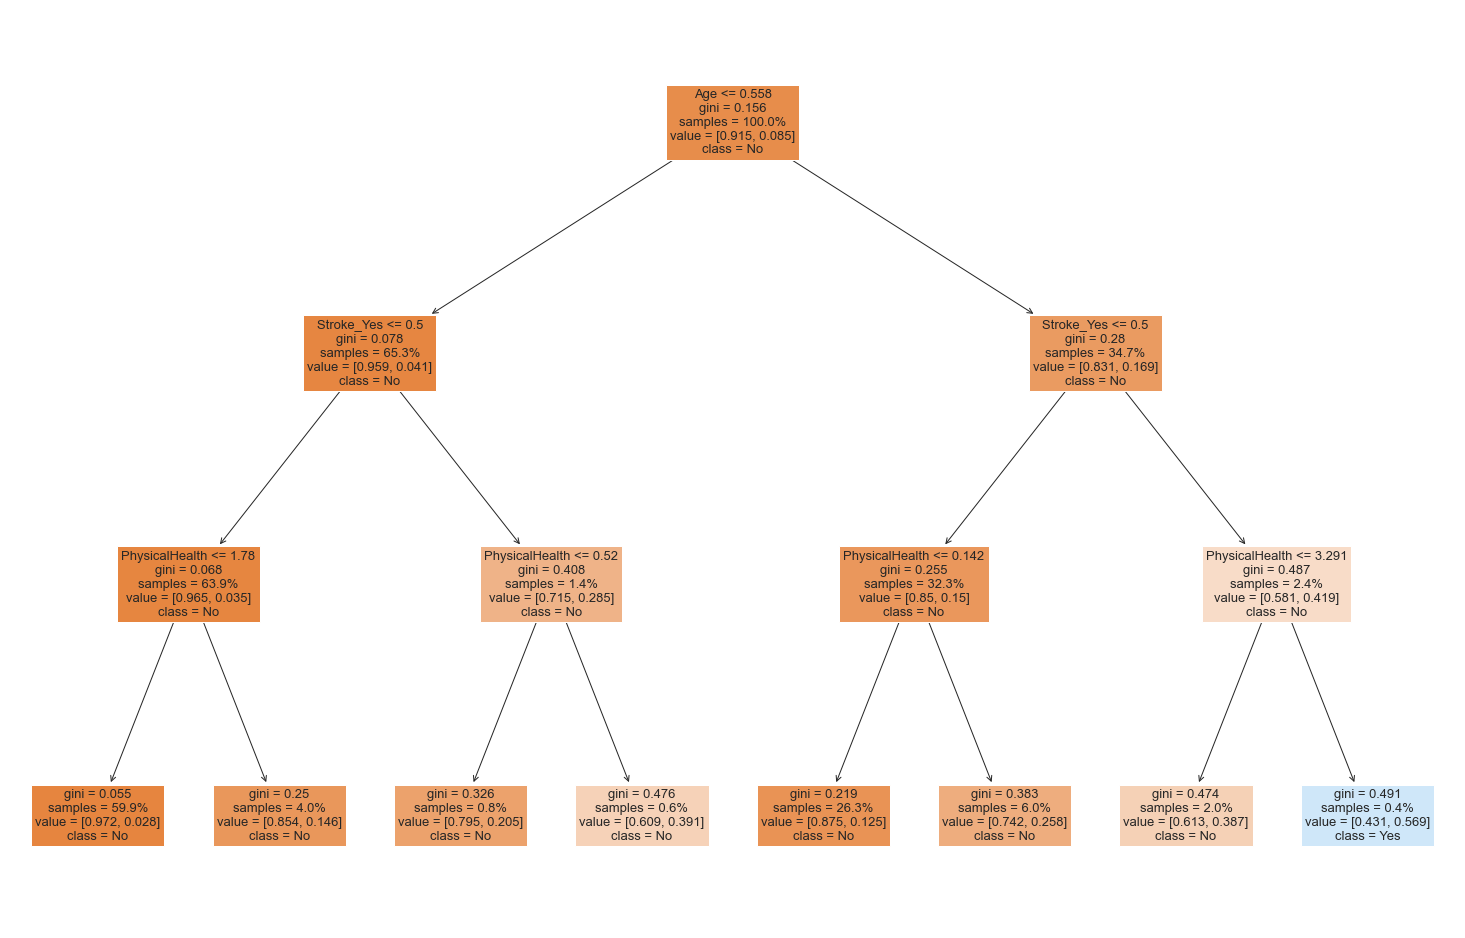

In [100]:
plt.figure(figsize=(26, 17))
plot_tree(dt_subset, feature_names=['BMI', 'PhysicalHealth',' MentalHealth', 'SleepTime', 'Age',
                                   'Stroke_Yes'],
         class_names=["No", "Yes"], impurity=True, proportion=True, filled=True,fontsize=13);

What does the Decision Tree diagram tell us about patients who are more and less likely to develop heart disease?


Based on this tree what variables would a patient need to have in order for this model to classify them as likely to develop heart disease?

### Machine Learning Walkthrough Recap


In this exercise where attempted to predict the onset of heart disease we:

- Familiarized ourselves with the data and its patterns by studying the data dictionary and conducting exploratory data analysis.
- We applied a number of feature engineering techniques to the data so as to prepare for machine learning.
- We employed three different machine learning models, two of which we parameter tuned in order maximize the performance of our machine learning modeling.
- We evaluated our models on a validation dataset to get a sense of how well it does on a out-of-sample dataset.
- We got analyzed the relationship between the features and target variable by using attributes provided by the model.